In [60]:
# must insert this statement to render the plots within the notebook
# this is specific to the ipython notebook
%matplotlib inline

## Import statements
# netcdf/numpy/xray/stats
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xray
from scipy.stats.stats import pearsonr

# OS interaction
import sys, pickle, os

# import subplots function for plotting
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context('talk')
import kgraph
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap

# Solargeometry
import solargeo

## Directory listing
dir_print = '/Users/karllapo/gdrive/SnowHydrology/proj/TurbulenceFeedbacks/Graphics'
dir_data = '/Users/karllapo/gdrive/SnowHydrology/proj/TurbulenceFeedbacks/data/SCP'

In [2]:
# Empty xray datasets
Atower = xray.Dataset()
Mtower = xray.Dataset()
Ctower = xray.Dataset()
soil_obs = xray.Dataset()
rad_obs = xray.Dataset()
flux_obs = xray.Dataset()

# Iterate through all documets
os.chdir(dir_data)
content = os.listdir(dir_data)
for nc in content:
    if nc[-3:] == '.nc':
        ds1 = xray.open_dataset(nc)
    else:
        continue    
    print(nc)   
    
    latitude = ds1.latitude[0,:]
    longitude = ds1.longitude[0,:]
    altitude = ds1.altitude[0,:]
    ds1 = ds1.drop('layout')
    ds1.coords['latitude'] = (('station'),latitude)
    ds1.coords['longitude'] = (('station'),longitude)
    ds1.coords['altitude'] = (('station'),altitude)

    ##############
    ## Organize ##
    ##############
    ## Variables to drop
    drop_variable_list = ['base_time',\
                            'GPSnsat',\
                            'GPSstat',\
                            'Lat',\
                            'Lon',\
                            'Alt',\
                            'Vdsm',\
                            'Wetness']
    ds1 = ds1.drop(drop_variable_list)

    drop_variable_to_match_list = ['Ifan',\
                                    'counts',\
                                    'Vheat',\
                                    'Vpile',\
                                    'Vmote',\
                                    'Tcase',\
                                    'Tbaro',\
                                    'kh2o',\
                                    'co2',\
                                    'Tau',\
                                    '_3m_',\
                                    'A15',\
                                    'A17',\
                                    'c2']
    for dv in drop_variable_to_match_list:
        ds_varnames = ds1.data_vars.keys()
        drop_variable_list = [s for s in ds_varnames if dv in s]
        ds1 = ds1.drop(drop_variable_list)
        
    ## Turbulence
    ds_varnames = ds1.data_vars.keys()
    flux_vars = [s for s in ds_varnames if 'w_tc' in s or 'w_h2o' in s]
    flux = xray.Dataset()
    # "Constants"
    lamb = 2264.76 # latent heat of vaporization kJ/kg or J/g
    cp = 1003 # J kg^-1 K^-1
    P = ds1['P_1m'].mean(dim='station')*100 # pressure Pa
    R = 287.058 # specific gas constant of dry air J kg^-1 K^-1
    row = P/(R*(ds1.T_0_5m.mean(dim='station')+273)) # density kg m^-3
    
    # For now, label fluxes according to their covariance variable name
    for fv in flux_vars:
        fv = str(fv)
        if 'w_tc' in fv:
            flux[fv] = ds1[fv]*cp*row
        elif 'w_h2o' in fv:
            flux[fv] = ds1[fv]*lamb

    # Drop labels that are uneeded            
    drop_variable_to_match_list = ['P','__','tc_']
    for dv in drop_variable_to_match_list:
        ds_varnames = ds1.data_vars.keys()
        drop_variable_list = [s for s in ds_varnames if dv in s]
        ds1 = ds1.drop(drop_variable_list)
        
    ## M tower
    ds_varnames = ds1.data_vars.keys()
    Mtower_vars = [s for s in ds_varnames if '_M' in s]
    Mt = xray.Dataset()
    for mtv in Mtower_vars:
        mtv = str(mtv)
        Mt[mtv] = ds1[mtv] 
    Mt.coords['latitude'] = ds1.latitude.sel(station='M21')
    Mt.coords['longitude'] = ds1.longitude.sel(station='M21')
    Mt.coords['altitude'] = ds1.altitude.sel(station='M21')
    ds1 = ds1.drop(Mtower_vars)

    ## C tower
    ds_varnames = ds1.data_vars.keys()
    Ctower_vars = [s for s in ds_varnames if '_C' in s]
    Ct = xray.Dataset()
    for ctv in Ctower_vars:
        ctv = str(ctv)
        Ct[ctv] = ds1[ctv]   
    Ct.coords['latitude'] = ds1.latitude.sel(station='C20')
    Ct.coords['longitude'] = ds1.longitude.sel(station='C20')
    Ct.coords['altitude'] = ds1.altitude.sel(station='C20')
    ds1 = ds1.drop(Ctower_vars)

    ## Soil
    ds_varnames = ds1.data_vars.keys()
    soil_vars = [s for s in ds_varnames if 'soil' in s or 'Gsfc' in s]
    soil = xray.Dataset()
    for sv in soil_vars:
        sv = str(sv)
        soil[sv] = ds1[sv]
    ds1 = ds1.drop(soil_vars)

    ## Radiation
    list_rad_vars = ['Rsw_in','Rsw_out','Rlw_in','Rlw_out','Rpile_in','Rpile_out']
    rad = xray.Dataset()
    for rv in list_rad_vars:
        rv = str(rv)
        rad[rv] = ds1[rv]        
    ds1 = ds1.drop(list_rad_vars)

    ## A towers (what's left over)
    At = xray.Dataset()
    for dv in ds1.data_vars.keys():
        dv = str(dv)
        At[dv] = ds1[dv]
        
    ############
    ## Concat ##
    ############
    if Atower.values() and Ctower.values() and Mtower.values() and rad_obs.values() \
        and soil_obs.values() and flux_obs.values():
        Atower = xray.concat([Atower,At],'time')
        Ctower = xray.concat([Ctower,Ct],'time')
        Mtower = xray.concat([Mtower,Mt],'time')
        soil_obs = xray.concat([soil_obs,soil],'time')
        rad_obs = xray.concat([rad_obs,rad],'time')
        flux_obs = xray.concat([flux_obs,flux],'time')
    else:
        Atower = At
        Ctower = Ct
        Mtower = Mt
        soil_obs = soil
        rad_obs = rad
        flux_obs = flux


isfs_qc_gtc_20120920.nc
isfs_qc_gtc_20120921.nc
isfs_qc_gtc_20120922.nc
isfs_qc_gtc_20120923.nc
isfs_qc_gtc_20120924.nc
isfs_qc_gtc_20120925.nc
isfs_qc_gtc_20120926.nc
isfs_qc_gtc_20120927.nc
isfs_qc_gtc_20120928.nc
isfs_qc_gtc_20120929.nc
isfs_qc_gtc_20120930.nc
isfs_qc_gtc_20121001.nc
isfs_qc_gtc_20121002.nc
isfs_qc_gtc_20121003.nc
isfs_qc_gtc_20121004.nc
isfs_qc_gtc_20121005.nc
isfs_qc_gtc_20121006.nc
isfs_qc_gtc_20121007.nc
isfs_qc_gtc_20121008.nc
isfs_qc_gtc_20121009.nc
isfs_qc_gtc_20121010.nc
isfs_qc_gtc_20121011.nc
isfs_qc_gtc_20121012.nc
isfs_qc_gtc_20121013.nc
isfs_qc_gtc_20121014.nc
isfs_qc_gtc_20121015.nc
isfs_qc_gtc_20121016.nc
isfs_qc_gtc_20121017.nc
isfs_qc_gtc_20121018.nc
isfs_qc_gtc_20121019.nc
isfs_qc_gtc_20121020.nc
isfs_qc_gtc_20121021.nc
isfs_qc_gtc_20121022.nc
isfs_qc_gtc_20121023.nc
isfs_qc_gtc_20121024.nc
isfs_qc_gtc_20121025.nc
isfs_qc_gtc_20121026.nc
isfs_qc_gtc_20121027.nc
isfs_qc_gtc_20121028.nc
isfs_qc_gtc_20121029.nc
isfs_qc_gtc_20121030.nc
isfs_qc_gtc_2012

In [3]:
##################################
## Save observations to netcdfs ##
##################################
os.chdir(dir_data)
Atower.to_netcdf('SCP.Atower.netcdf')
Ctower.to_netcdf('SCP.Ctower.netcdf')
Mtower.to_netcdf('SCP.Mtower.netcdf')
soil_obs.to_netcdf('SCP.soil_obs.netcdf')
rad_obs.to_netcdf('SCP.rad_obs.netcdf')
flux_obs.to_netcdf('SCP.flux_obs.netcdf')

In [48]:
###############
## Aggregate ##
###############

## 30 minute averages of fluxes
flux_obs_30m = flux_obs.resample(freq='30Min',how='mean',dim='time')
rad_obs_30m = rad_obs.resample(freq='30Min',how='mean',dim='time')
soil_obs_30m = soil_obs.resample(freq='30Min',how='mean',dim='time')

## Mean ground heat flux @ both sites
soil_obs_30m['Gsfc'] = xray.concat([soil_obs_30m.Gsfc_c,\
                                    soil_obs_30m.Gsfc_g],dim='site').mean(dim='site')
soil_obs_30m['Gsoil_5cm'] = xray.concat([soil_obs_30m.Gsoil_5cm_c,\
                                    soil_obs_30m.Gsoil_5cm_g],dim='site').mean(dim='site')



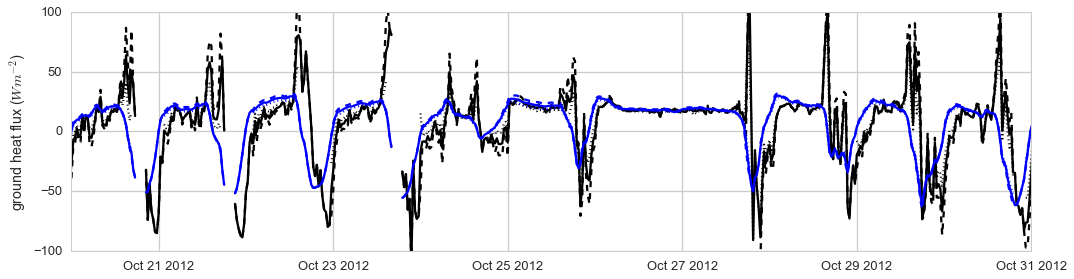

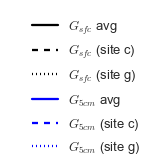

In [61]:
## Ground heat flux during snow
fig,ax = plt.subplots(1,1,figsize=(15,4))

# Surface heat flux
ax.plot(soil_obs_30m.time,soil_obs_30m.Gsfc,'k',label=r'$G_{sfc}$ avg')
ax.plot(soil_obs_30m.time,soil_obs_30m.Gsfc_c,'k--',label=r'$G_{sfc}$ (site c)')
ax.plot(soil_obs_30m.time,soil_obs_30m.Gsfc_g,'k:',label=r'$G_{sfc}$ (site g)')

# 5cm heat flux
ax.plot(soil_obs_30m.time,soil_obs_30m.Gsoil_5cm,'b',label=r'$G_{5cm}$ avg')
ax.plot(soil_obs_30m.time,soil_obs_30m.Gsoil_5cm_c,'b--',label=r'$G_{5cm}$ (site c)')
ax.plot(soil_obs_30m.time,soil_obs_30m.Gsoil_5cm_g,'b:',label=r'$G_{5cm}$ (site g)')

# Formating
ax.set_xlim(datetime(2012,10,20),datetime(2012,10,31))
ax.set_ylim(-100,100)
ax.set_ylabel('ground heat flux ($Wm^{-2}$)')

## Legend (separate figure)
leg_fig = plt.figure(figsize=(2,2))
leg_ax = plt.axes()
leg_ax.axis('off')
_out = leg_ax.legend(*ax.get_legend_handles_labels(),ncol=1, borderaxespad=0.)

os.chdir(dir_print)
fig.tight_layout()
fig.savefig('SCP.GroundHeatFlux.Oct20_Oct31.pdf')
leg_fig.savefig('SCP.GroundHeatFlux.Oct20_Oct31.Legend.pdf')

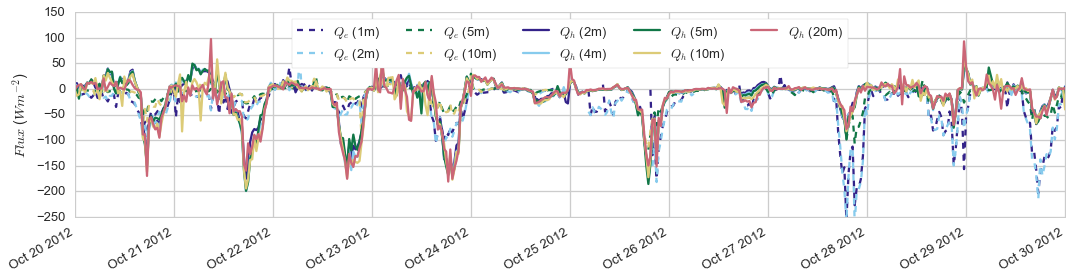

In [75]:
## Turubulent Fluxes during snow
fig, ax = plt.subplots(1,1,figsize=(15,4))
colsche = kgraph.SRON(5)

# Qe
ax.plot(flux_obs_30m.time,-flux_obs_30m.w_h2o__1m_M,'--',color=colsche[0,:],label='$Q_e$ (1m)')
ax.plot(flux_obs_30m.time,-flux_obs_30m.w_h2o__2m_M,'--',color=colsche[1,:],label='$Q_e$ (2m)')
ax.plot(flux_obs_30m.time,-flux_obs_30m.w_h2o__5m_M,'--',color=colsche[2,:],label='$Q_e$ (5m)')
ax.plot(flux_obs_30m.time,-flux_obs_30m.w_h2o__10m_M,'--',color=colsche[3,:],label='$Q_e$ (10m)')

# Qh
ax.plot(flux_obs_30m.time,-flux_obs_30m.w_tc__2m_M,color=colsche[0,:],label='$Q_h$ (2m)')
ax.plot(flux_obs_30m.time,-flux_obs_30m.w_tc__4m_M,color=colsche[1,:],label='$Q_h$ (4m)')
ax.plot(flux_obs_30m.time,-flux_obs_30m.w_tc__5m_M,color=colsche[2,:],label='$Q_h$ (5m)')
ax.plot(flux_obs_30m.time,-flux_obs_30m.w_tc__10m_M,color=colsche[3,:],label='$Q_h$ (10m)')
ax.plot(flux_obs_30m.time,-flux_obs_30m.w_tc__20m_M,color=colsche[4,:],label='$Q_h$ (20m)')

ax.legend(loc='best',frameon=True,ncol=5)
ax.set_ylim(-250,150)
ax.set_ylabel('$Flux$ ($Wm^{-2}$)')
ax.set_xlim(datetime(2012,10,20),datetime(2012,10,30))
fig.autofmt_xdate()
fig.tight_layout()

os.chdir(dir_print)
fig.savefig('SCP.NetTurb.Oct20_Oct31.pdf')

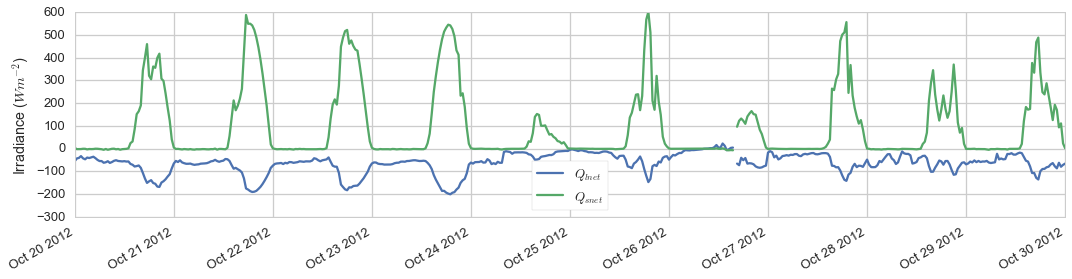

In [85]:
## Radiative Fluxes during snow
fig, ax = plt.subplots(1,1,figsize=(15,4))
ax.plot(flux_obs_30m.time,rad_obs_30m.Rlw_in-rad_obs_30m.Rlw_out,label='$Q_{lnet}$')
ax.plot(flux_obs_30m.time,rad_obs_30m.Rsw_in-rad_obs_30m.Rsw_out,label='$Q_{snet}$')

ax.legend(loc='best',frameon=True)
ax.set_ylim(-300,600)
ax.set_ylabel('Irradiance ($Wm^{-2}$)')
ax.set_xlim(datetime(2012,10,20),datetime(2012,10,30))
fig.autofmt_xdate()

os.chdir(dir_print)
fig.tight_layout()
fig.savefig('SCP.NetRad.Oct20_Oct31.pdf')

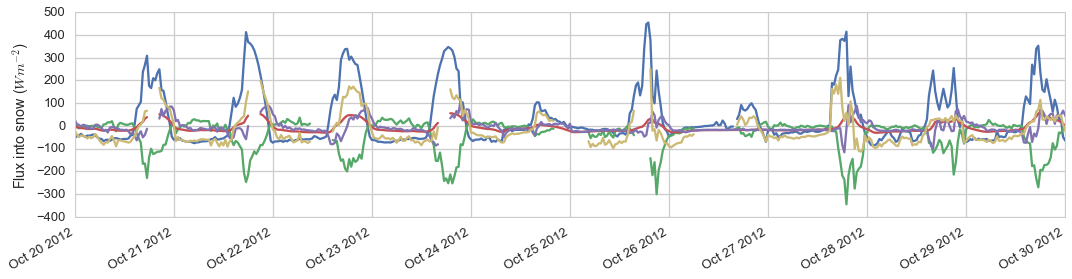

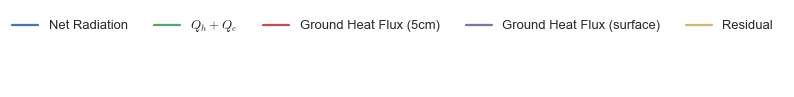

In [82]:
## Net energy balance during snow
fig, ax = plt.subplots(1,1,figsize=(15,4))

Rnet = rad_obs_30m.Rlw_in - rad_obs_30m.Rlw_out + rad_obs_30m.Rsw_in - rad_obs_30m.Rsw_out # Net rad
LE1 = flux_obs_30m.w_h2o__1m_M # J s^-1 m^-2
LE2 = flux_obs_30m.w_h2o__2m_M # J s^-1 m^-2
LE5 = flux_obs_30m.w_h2o__5m_M # J s^-1 m^-2
LE10 = flux_obs_30m.w_h2o__10m_M # J s^-1 m^-2

H2 = flux_obs_30m.w_tc__2m_M
H4 = flux_obs_30m.w_tc__4m_M
H5 = flux_obs_30m.w_tc__5m_M
H10 = flux_obs_30m.w_tc__10m_M
H20 = flux_obs_30m.w_tc__20m_M

H = xray.concat([H2,H4],'height').mean(dim='height') # J m^-2 s^-1
LE = xray.concat([LE1,LE2],'height').mean(dim='height') # J m^-2 s^-1
Qeh = LE+H # Net turbulence

## Plot surface energy balance
ax.plot(rad_obs_30m.time,Rnet,label='Net Radiation')
ax.plot(rad_obs_30m.time,-Qeh,label='$Q_h+Q_e$')
ax.plot(rad_obs_30m.time,-soil_obs_30m.Gsoil_5cm,label='Ground Heat Flux (5cm)')
ax.plot(rad_obs_30m.time,-soil_obs_30m.Gsfc,label='Ground Heat Flux (surface)')
ax.plot(H.time,Rnet - Qeh - soil_obs_30m.Gsfc,label='Residual')
ax.set_ylim(-400,500)
ax.set_xlim(datetime(2012,10,20),datetime(2012,10,30))
fig.autofmt_xdate()
ax.set_ylabel('Flux into snow ($Wm^{-2}$)')

## Legend (separate figure)
leg_fig = plt.figure(figsize=(12,1))
leg_ax = plt.axes()
leg_ax.axis('off')
_out = leg_ax.legend(*ax.get_legend_handles_labels(),ncol=5, borderaxespad=0.)

os.chdir(dir_print)
fig.tight_layout()
fig.savefig('SCP_TowerM.EnergyBudget.pdf')
leg_fig.savefig('SCP_TowerM.EnergyBudget.Legend.pdf')

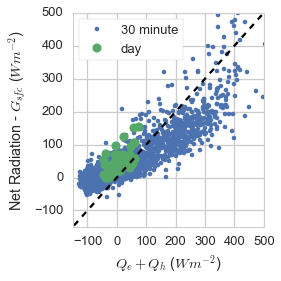

In [84]:
## Energy conservation
plt.figure(figsize=(4,4))
ax = plt.axes()
plt.plot(Rnet - soil_obs_30m.Gsfc,Qeh,'.',label='30 minute')
plt.plot( (Rnet - soil_obs_30m.Gsfc).resample(freq='D',how='mean',dim='time'),\
         Qeh.resample(freq='D',how='mean',dim='time'),'o',label='day')
plt.plot(np.array((-200,500)),np.array((-200,500)),'k--')

ax.set_ylabel('Net Radiation - $G_{sfc}$ ($Wm^{-2}$)')
ax.set_xlabel('$Q_e+Q_h$ ($Wm^{-2}$)')
ax.legend(loc='best',frameon=True)
ax.set_ylim(-150,500)
ax.set_xlim(-150,500)
plt.tight_layout()

os.chdir(dir_print)
plt.savefig('SCP.EnergyBudgetClosure.pdf')

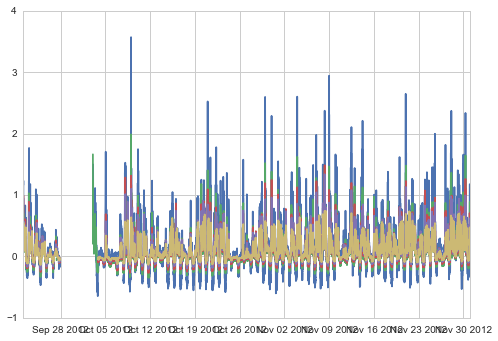

In [345]:
# Temparature difference between each level of 'M' tower
_out = plt.plot(Mtower.time,(Mtower.T_2_5m_M-Mtower.T_1m_M)/1)
_out = plt.plot(Mtower.time,(Mtower.T_4m_M-Mtower.T_1m_M)/3)
_out = plt.plot(Mtower.time,(Mtower.T_6m_M-Mtower.T_1m_M)/5)
_out = plt.plot(Mtower.time,(Mtower.T_8m_M-Mtower.T_1m_M)/7)
_out = plt.plot(Mtower.time,(Mtower.T_15m_M-Mtower.T_1m_M)/14)

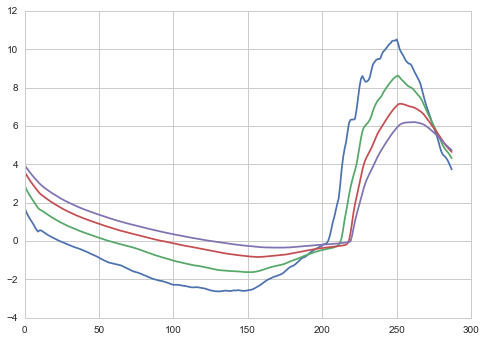

In [335]:
_out = plt.plot(ds1.Tsoil_0_6cm_c)
_out = plt.plot(ds1.Tsoil_1_9cm_c)
_out = plt.plot(ds1.Tsoil_3_1cm_c)
_out = plt.plot(ds1.Tsoil_4_4cm_c)

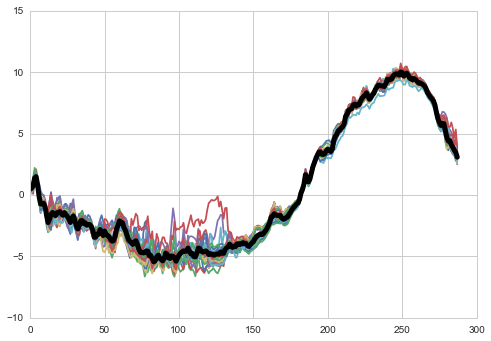

In [338]:
plt.plot(ds1['T_0_5m'])
plt.plot(ds1['T_0_5m'].mean(dim='station'),'k', lw=5)


(0, 500)

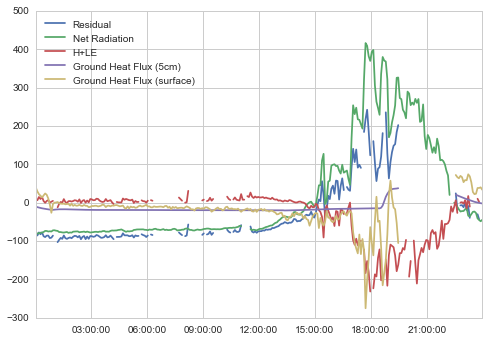

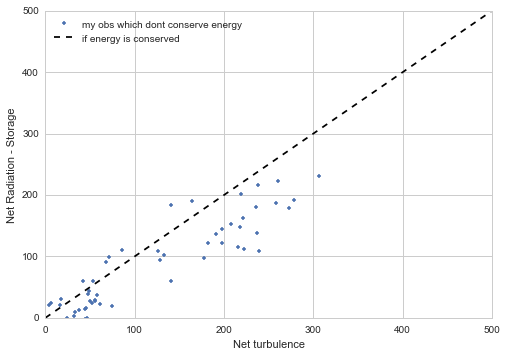

In [340]:
#### Test of how to calculate LE and H
# lamb = 2264.76 # latent heat of vaporization kJ/kg or J/g
# cp = 1003 # J kg^-1 K^-1
# P = ds1['P_1m'].mean(dim='station')*100 # pressure Pa
# R = 287.058 # specific gas constant of dry air J kg^-1 K^-1
# row = P/(R*(ds1.T_0_5m.mean(dim='station')+273)) # density kg m^-3

# LE1 = lamb*ds1.w_h2o__1m_M # J s^-1 m^-2
# LE2 = lamb*ds1.w_h2o__2m_M # J s^-1 m^-2
# LE5 = lamb*ds1.w_h2o__5m_M # J s^-1 m^-2
# LE10 = lamb*ds1.w_h2o__10m_M # J s^-1 m^-2
# H = cp*row*ds1.w_tc__0_5m_M # J m^-2 s^-1

# Rnet = ds1.Rlw_in - ds1.Rlw_out + ds1.Rsw_in - ds1.Rsw_out # Net rad
# F = LE2+H # Net turbulence

# # Plot surface energy balance
# plt.figure()
# plt.plot(ds1.time,Rnet - F - ds1.Gsoil_5cm_c,label='Residual')
# plt.plot(ds1.time,Rnet,label='Net Radiation')
# plt.plot(ds1.time,-F,label='H+LE')
# plt.plot(ds1.time,-ds1.Gsoil_5cm_c,label='Ground Heat Flux (5cm)')
# plt.plot(ds1.time,-ds1.Gsfc_c,label='Ground Heat Flux (surface)')
# plt.axes().legend(loc='best')

# plt.figure()
# ax = plt.axes()
# plt.plot(Rnet-ds1.Gsfc_c,F,'.',label='my obs which dont conserve energy')
# plt.plot(np.array((0,500)),np.array((0,500)),'k--',label='if energy is conserved')

# ax.set_ylabel('Net Radiation - Storage')
# ax.set_xlabel('Net turbulence')
# ax.legend(loc='best')
# ax.set_ylim(0,500)
# ax.set_xlim(0,500)

(-200, 200)

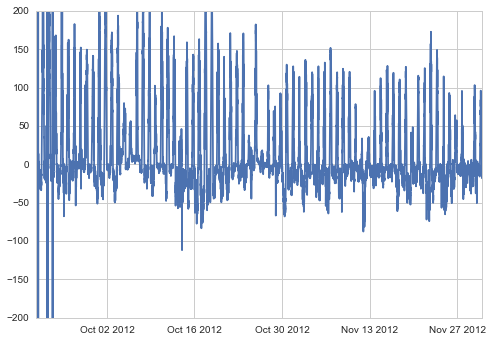

In [382]:
plt.plot(flux_obs.time,flux_obs.w_tc__1m.mean(dim='station'))
plt.axes().set_ylim(-200,200)